# 1.1「学習済みVGGモデル」を使用する方法

- 本ファイルでは、学習済みのVGGモデルを使用し、未知の画像（ゴールデンレトリバー）を分類します


# 学習目標

1.	PyTorchでImangeNetデータセットでの学習済みモデルをロードできるようになる
2.	VGGモデルについて理解する
3.	入力画像のサイズや色を変換できるようになる



# 事前準備


1. 書籍の指示に従い、make_folders_and_data_downloads.ipynbを実行して、本章で使用するデータをダウンロード


2. PyTorchのインストールページ（ https://pytorch.org/get-started/locally/ ）を参考に、PyTorch1.0をインストール


conda install pytorch-cpu torchvision-cpu -c pytorch

（Windowsで、GPUなしの環境をcondaでインストールする場合）


3. Matplotlibをインストール

conda install -c conda-forge matplotlib 


# パッケージのimportとPyTorchのバージョンを確認

In [1]:
# パッケージのimport
import numpy as np
import json
from PIL import Image #画像読み込みに使う
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torchvision import models, transforms


In [2]:
# PyTorchのバージョン確認
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.11.0+cu113
Torchvision Version:  0.12.0+cu113


In [3]:
print(torch.cuda.is_available())

True


# VGG-16の学習済みモデルをロード

In [4]:
# 学習済みのVGG-16モデルをロード
# 初めて実行する際は、学習済みパラメータをダウンロードするため、実行に時間がかかります

# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)
net.eval()  # 推論モードに設定

# モデルのネットワーク構成を出力
print(net)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

# 入力画像の前処理クラスを作成

In [5]:
# 入力画像の前処理のクラス
class BaseTransform():
    """
    画像のサイズをリサイズし、色を標準化する。

    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.base_transform = transforms.Compose([ # compose は複数のtransformを連続して行う
            transforms.Resize(resize),  # 短い辺の長さがresizeの大きさになる
            transforms.CenterCrop(resize),  # 画像中央をresize × resizeで切り取り
            transforms.ToTensor(),  # Torchテンソルに変換
            transforms.Normalize(mean, std)  # 色情報の標準化
        ])

    def __call__(self, img):#こうするとインスタンスを関数のように呼び出せる
        return self.base_transform(img)


In [6]:
# 画像前処理の動作を確認

# 1. 画像読み込み
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)  # [高さ][幅][色RGB]

In [7]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

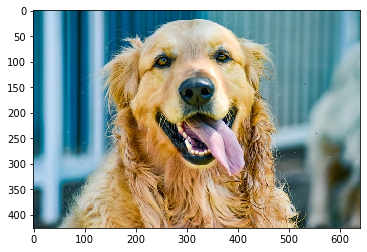

In [8]:
# 2. 元の画像の表示
plt.imshow(img)
plt.show()

# 3. 画像の前処理と処理済み画像の表示
resize = 224
mean = (0.485, 0.456, 0.406)#これらの値はILSVRCデータセットの教師データから決定している
std = (0.229, 0.224, 0.225)# 学習済みのVGG-16モデルがこの前処理を行った画像で学習を行っているので同じようにする
transform = BaseTransform(resize, mean, std)

In [9]:
type(transform)

__main__.BaseTransform

In [10]:
img_transformed = transform(img)  # torch.Size([3, 224, 224])

In [11]:
type(img_transformed)

torch.Tensor

In [12]:
img_transformed.size()

torch.Size([3, 224, 224])

In [13]:
# (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
img_transformed = img_transformed.numpy().transpose((1, 2, 0)) # 軸の入れ替え

In [14]:
type(img_transformed)

numpy.ndarray

In [15]:
img_transformed.shape

(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


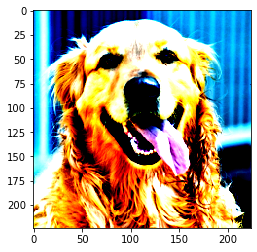

In [17]:
plt.imshow(img_transformed)
plt.show()

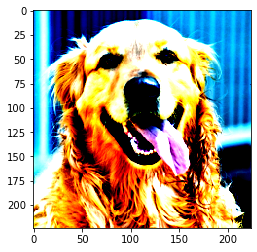

In [18]:
img_transformed = np.clip(img_transformed, 0, 1)
plt.imshow(img_transformed)
plt.show()

# 出力結果からラベルを予測する後処理クラスを作成

In [20]:
# ILSVRCのラベル情報をロードし辞書型変数を生成します
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))
ILSVRC_class_index


{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [21]:
type(ILSVRC_class_index)

dict

In [23]:
# 出力結果からラベルを予測する後処理クラス
class ILSVRCPredictor():
    """
    ILSVRCデータに対するモデルの出力からラベルを求める。

    Attributes
    ----------
    class_index : dictionary
            クラスindexとラベル名を対応させた辞書型変数。
    """

    def __init__(self, class_index):
        self.class_index = class_index

    def predict_max(self, out):
        """
        確率最大のILSVRCのラベル名を取得する。

        Parameters
        ----------
        out : torch.Size([1, 1000])
            Netからの出力。

        Returns
        -------
        predicted_label_name : str
            最も予測確率が高いラベルの名前
        """
        maxid = np.argmax(out.detach().numpy())
        predicted_label_name = self.class_index[str(maxid)][1]

        return predicted_label_name


# 学習済みVGGモデルで手元の画像を予測

In [24]:
# ILSVRCのラベル情報をロードし辞意書型変数を生成します
ILSVRC_class_index = json.load(open('./data/imagenet_class_index.json', 'r'))

# ILSVRCPredictorのインスタンスを生成します
predictor = ILSVRCPredictor(ILSVRC_class_index)

# 入力画像を読み込む
image_file_path = './data/goldenretriever-3724972_640.jpg'
img = Image.open(image_file_path)  # [高さ][幅][色RGB]

# 前処理の後、バッチサイズの次元を追加する
transform = BaseTransform(resize, mean, std)  # 前処理クラス作成
img_transformed = transform(img)  # torch.Size([3, 224, 224])
inputs = img_transformed.unsqueeze_(0)  # torch.Size([1, 3, 224, 224]) _はinplaceするかどうか

# モデルに入力し、モデル出力をラベルに変換する
out = net(inputs)  # torch.Size([1, 1000])
result = predictor.predict_max(out)

# 予測結果を出力する
print("入力画像の予測結果：", result)


入力画像の予測結果： golden_retriever


以上